## Can we Effectively Predict the Course of the Cryptocurrency Market?

In machine learning, event-driven models to predict stock prices dominate the headlines. Many people use knowledge maps to construct a set of keywords to filter relevant textual data (i.e. the content of popular tweets and news headlines) for training. An inherently problematic aspect of this approach is that the performance of an event-driven model is ultimately dependent on a pre-determined set of key words; the efficacy of the entire model thus comes into questions, as the real world is vastly more complex than relationships given by a knowledge map.

We believe that there exist strong connections between the performance of different major markets. Our hypothesis is grounded in the following observation: major markets tend to have mutual dependencies (e.g. when gas price rises as a result of disturbances in the crude oil market, fewer people will drive cars) and total capitals invested into markets tend to be relatively stable in a short period of time (e.g. when investors get back money from one market, they want to invest other markets because they don't want their money to shrink in banks). 

If we discover meaningful relations between different markets, we can use ensemble methods and extant models for predicting market performance to construct our own organic model to predict the course of a major market. This can be seen as an extension of knowledge map through use of trans-market information. As the title of our project alludes, we will chiefly target the cryptocurrency market, as we believe it is most sensitive to other markets. Our primary motivating factor is that reserarch on event-driven models for cryptocurrency prices is quite scant.

### Breakdown

The following were the major junctures in our project:

1. We first scrape webpages from Yahoo finance, Google finance, coincapmarket.com and other websites to obtain price data of cryptocurrencies and indexes of the markets in which are interested in observing potential parallels (gold, crude oil, etc.). 
2. We then use this data to conduct a hypothesis test to see if other markets have significant relationships with cryptocurrency market.
3. We collect tweet texts filtered by naïve keywords sets and use these text data to train models to predict different markets separately.
4. With correlations and naïve models in hand, we want to combine them with ensemble methods to see if models predicting other markets can help improve our naïve model for predicting the cryptocurrency market.

### Collecting market prices variations from stock indices

First, our goal is to collect prices from different markets. While there are many methods to retrieve the data, we will use Google Finance API in this project. The package can be installed running the following command in terminal:

$ `pip install googlefinance.client`

In [3]:
from googlefinance.client import get_price_data
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The Google Finance API includes a method `get_price_data()` that returns a `pandas.DataFrame` of the prices of a market (labeled by a stock market index) for a given period (e.g. last two years, last six months) and interval (given in seconds). An early obstacle we encountered in getting data from this API was that missing data was common when examining across smaller intervals (seconds, minutes, hours, and days). 

Since our goal is to perform thorough comparisons of the markets on an aligned timeline, we'll first retrieve prices on a day to day basis (interval = 86400 seconds). Then, we can compute monthly means to preemptively take of care of missing data points and make sure we synchronize the number of datapoints that we manipulate for all markets.

Additionally, for a given time unit, the API provides different prices (cf. [OHLC chart](https://en.wikipedia.org/wiki/Open-high-low-close_chart)). For this project, we will only use the closing price. The following is the code that executes on this approach for data collection:

In [4]:
def collect_market(stock, period='1Y', frequency='MONTHLY'):
    """ Given a stock index, a period and a frequency, collects the daily closing price of the market
    Args:
        stock (string) : stock symbol (ex: 'AAPL')
        period (string) : period (ex: '1Y' = 1 year, '6M' = 6 months, '1d' = 1 day)
        frequency (string) : frequency of data ('DAILY' = per day, 'MONTHLY' = per month)
    Returns:
        prices (pandas.DataFrame) : daily closing prices of the corresponding market
    """
    param = {}
    param['q'] = stock
    param['i'] = '86400' # Daily interval
    param['p'] = period
    prices = get_price_data(param)
    if frequency == 'MONTHLY': # Compute the mean by month if frequency is MONTHLY
        prices['date'] = prices.index.map(lambda x: x.strftime('%Y-%m'))
        prices = prices.groupby('date').mean()
    return prices['Close']

We focus our analysis on Bitcoin, as it is currently the most popular cryptocurrency and generally considered to be the canonical representative of the performance of most coins in the market. With the method defined above, we can collect the month by month prices from the last year (2017-05 to 2018-05) using the BTCUSD index.

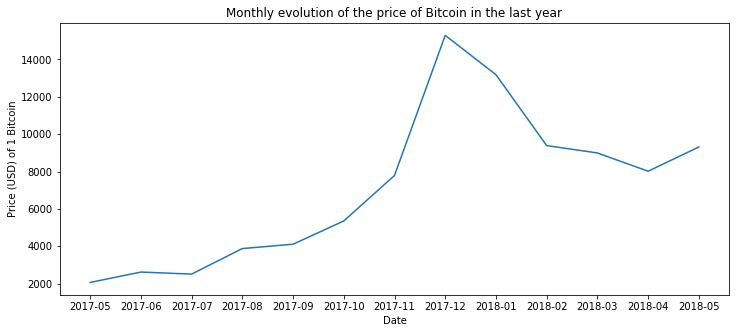

In [5]:
btc_prices = collect_market('BTCUSD')
plt.figure(figsize=(12, 5))
plt.xlabel('Date')
plt.ylabel('Price (USD) of 1 Bitcoin')
plt.title('Monthly evolution of the price of Bitcoin in the last year')
plt.plot(btc_prices);

To conduct our correlation tests, we are actually more interested in the variations of prices rather than in the prices themselves. Let's define a simple function that computes the month by month percent variations of a given set of monthly prices.

In [6]:
def prices_variations(prices):
    """ Given prices from a market, compute the variations between one unit of time and its predecessor
    Args:
        prices (pandas.DataFrame) : daily closing prices of a market
    Returns:
        variations (numpy.ndarray) : percentage variations between two units of time 
    """
    return np.array([100*(x-prices[i-1])/prices[i-1] for i, x in enumerate(prices)][1:])

Now, let's use this function to compute and visualize the variations of the prices of Bitcoin over the last year.

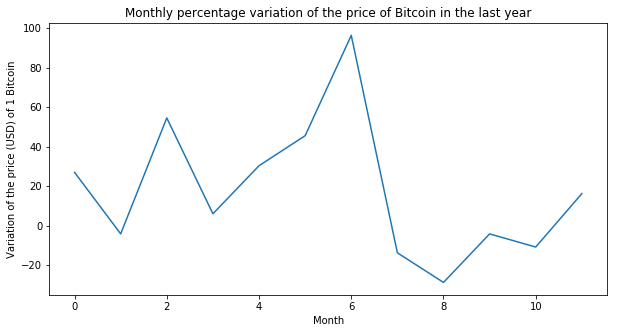

In [7]:
btc_var = prices_variations(btc_prices)
plt.figure(figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Variation of the price (USD) of 1 Bitcoin')
plt.title('Monthly percentage variation of the price of Bitcoin in the last year')
plt.plot(btc_var);

Now, we can collect the variations of other markets in the same way. In this project, we will focus on the following tickers for indexes that we will deem fit for reflection of the performance of the entire market sector:
* Technology: NDAQ
* Renewable energy: OSPTX
* Real estate: DJUSRE
* Crude oil: CL1
* Gold: HUI

In [8]:
def collect_variations(stocks, period='1Y', frequency='MONTHLY'):
    """ Given a list of stock indexes, a period and a frequency, collects the variations of the markets
    Args:
        stocks (list) : list of stock symbols (ex: ['NDAQ', 'OSPTX'])
        period (string) : period (ex: '1Y' = 1 year, '6M' = 6 months, '1d' = 1 day)
        frequency (string) : frequency of data ('DAILY' = per day, 'MONTHLY' = per month)
    Returns:
        stocks_var (dict) : variations of each market
    """
    stocks_var = {}
    for stock in stocks:
        prices = collect_market(stock, period, frequency)
        stocks_var[stock] = prices_variations(prices)
    return stocks_var

In [9]:
stocks = ['NDAQ', 'OSPTX', 'DJUSRE', 'CL1', 'HUI'] # List of stock indexes
stocks_var = collect_variations(stocks) # Collect the variations of each market

### Tests of Pearson's correlation

To investigate the correlation between the Bitcoin market and the other markets, we will conduct tests involving Pearson's correlation. The Pearson's Correlation Coefficient is a measure of the linear correlation between two variables $X$ and $Y$. The main idea of the test is to compute a p-value from this coefficient to ascertain the strength of the correlation between variables -- in our case, the variables are the fluctuations in the markets. 

This test can be conducted in six steps:

#### Step 1: specify the null hypothesis and the alternative hypothesis

$H_0: \rho = 0$ (no linear correlation) $\qquad$ $H_1: \rho \neq 0$ (linear correlation)

#### Step 2: choose a significance level

We want to provide results with a 95% confidence level, thus we set $\alpha = 0.05$

#### Step 3: compute the sample value of Pearson's correlation coefficient

Pearson's correlation coefficient (also referred to as Pearson's r) is computed with the following formula:

$r = \frac{\sum XY-\frac{\sum X \sum Y}{N}}{\sqrt{(\sum X^2-\frac{(\sum X)^2}{N})\times(\sum Y^2-\frac{(\sum Y)^2}{N})}}$

Below is the code for this computation:

In [10]:
def pearson_coefficient(X, Y):
    """ Computes the Pearson's correlation coefficient
    Args:
        X (list) : values of the first sample
        Y (list) : values of the second sample
    Returns:
        r (float) : Pearson's correlation coefficient
    """
    return np.divide(np.sum(X*Y)-np.sum(X)*np.sum(Y)/len(X),
                     np.sqrt((np.sum(X**2)-np.sum(X)**2/len(X))*(np.sum(Y**2)-np.sum(Y)**2/len(X))))

#### Step 4: compute the T-score

We will now compute the T-score which will be used to in our evaluation of the p-value and the ultimate conclusion on the strength of the correlation. The formula of the T-score is given by:

$t = \frac{r\sqrt{N-2}}{\sqrt{1-r^2}}$

And, in Python code, we have:

In [11]:
def t_score(sample_size, r):
    """ Computes the T-score
    Args:
        sample_size (int) : size of the sample
        r (float) : Pearson's correlation coefficient
    Returns:
        t (float) : T-score
    """
    return np.divide(r*np.sqrt(sample_size-2), np.sqrt(1-r**2)) if abs(r) != 1 else float('Inf')

#### Step 5: compute the p-value

The p-value can be obtained from the T-score and degree of freedom. In our case, the degree of freedom, the number variables in our computation that can vary, is given by $N-2$, since we are comparing two markets at a time.

In Python,

In [12]:
def p_value(t, df):
    """ Given a T-score and a degree of freedom, computes the p-value
    Args:
        t (float) : T-score
        df (int) : degree of freedom
    Returns:
        p (float) : p-value
    """
    return stats.t.sf(np.abs(t), df)*2

#### Step 6: conclude

If the p-value from Step 5 is less than the significance level of Step 2, then the correlation is significant and we reject $H_0$. Otherwise, there is no strong evidence of linear correlation between $X$ and $Y$ and we do not reject $H_0$. We can encapsulate the entire process in the function `person_test`:

#### Summarization of the six steps in one function

In [13]:
def pearson_test(X, Y, alpha=0.05):
    """ Conduct a Pearson's correlation test
    Args:
        X (list) : values of first sample
        Y (list) : values of second sample
        alpha (float) : significance level
    """
    r = pearson_coefficient(X, Y)
    t = t_score(len(X), r)
    p = p_value(t, len(X) - 2) # df = N - 2
    is_significant = p < alpha
    print('alpha = {} ; r = {} ; t = {} ; p = {} ; correlation = {} ; reject H0 = {}'
          .format(alpha, round(r, 3), round(t, 3), round(p, 3), is_significant, is_significant))

As an initial verification of the viability of our code for the test, we can test it with two identical markets; naturally, we expect a complete correlation.

In [14]:
pearson_test(btc_var, btc_var)

alpha = 0.05 ; r = 1.0 ; t = inf ; p = 0.0 ; correlation = True ; reject H0 = True


### Correlation between cryptomarket and other markets

Now, let's conduct the Pearson's test on the cryptomarket and the other markets!

In [15]:
for stock in stocks:
    print('-- Test on {}'.format(stock))
    pearson_test(btc_var, stocks_var[stock])
    print()

-- Test on NDAQ
alpha = 0.05 ; r = 0.103 ; t = 0.329 ; p = 0.749 ; correlation = False ; reject H0 = False

-- Test on OSPTX
alpha = 0.05 ; r = 0.368 ; t = 1.253 ; p = 0.239 ; correlation = False ; reject H0 = False

-- Test on DJUSRE
alpha = 0.05 ; r = 0.395 ; t = 1.36 ; p = 0.204 ; correlation = False ; reject H0 = False

-- Test on CL1
alpha = 0.05 ; r = 0.019 ; t = 0.061 ; p = 0.952 ; correlation = False ; reject H0 = False

-- Test on HUI
alpha = 0.05 ; r = -0.022 ; t = -0.068 ; p = 0.947 ; correlation = False ; reject H0 = False



As we can see, with a 95% confidence level, we are compelled to conclude that there is no significant linear correlation between the Bitcoin market and the other markets in the last year. Thus, it must be the case that Bitcoin's volatility precludes the observation of any appreciable correlation, or that our data is insufficient.

### Correlation between different cryptocurrencies

While we couldn't find a strong correlation between the Bitcoin market and the other markets, it is likely that there are correlations between different cryptomarkets. In this section, we will build a heatmap showing how cryptocurrencies are correlated to each other, rather than indexes representing other markets. The heatmap will reflect the results of pairwise Pearson's Correlation Tests on the following coins:

* BTCUSD: Bitcoin
* BCH: Bitcoin Cash
* ETH: Ethereum
* LTC: Litecoin
* NEO: NEO (formerly ANS)
* EOS: EOSIO

In [16]:
def collect_coefficients(stocks_var):
    """ Given a list of stocks variations, compute the Pearson's correlation coefficient for each pair of stocks
    Args:
        stocks_var (dict) : variations of each market with n keys
    Returns:
        coeff (numpy.ndarray) : n*n matrix of Pearson's correlation coefficient
    """
    stocks = list(stocks_var.keys())
    return np.array([[pearson_coefficient(stocks_var[stock], stocks_var[other]) for other in stocks]
                     for stock in stocks])

In [17]:
crypto = ['BTCUSD', 'BCH', 'ETH', 'LTC', 'NEO', 'EOS'] # List of cryptocurrencies
crypto_var = collect_variations(crypto) # Collect the variations of each cryptocurrency
coeff = collect_coefficients(crypto_var) # Collect the Pearson's coefficients

Using `Matplotlib.plt.subplots` to build our heatmap will afford a clear visualization of what we mean

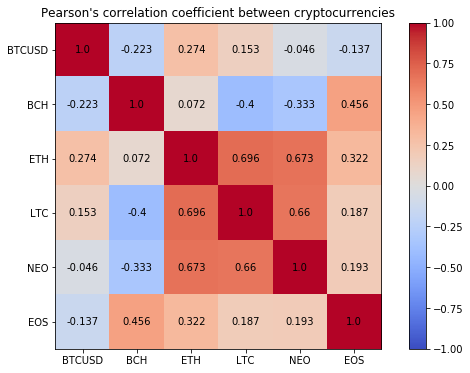

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(coeff, vmin=-1, vmax=1, cmap="coolwarm")
ax.set_xticks(np.arange(len(crypto)))
ax.set_yticks(np.arange(len(crypto)))
ax.set_xticklabels(crypto)
ax.set_yticklabels(crypto)
for row in range(len(coeff)):
    for col in range(len(coeff)):
        ax.text(col, row, round(coeff[row][col], 3), ha='center', va='center')
ax.set_title("Pearson's correlation coefficient between cryptocurrencies")
ax.figure.colorbar(im, ax=ax)
plt.show()

As the heatmap shows, there is a moderately strong positive linear correlation between LTC and NEO, ETH and NEO, and LTC and ETH.

### A Dose of Reality
Our project's aim was to perform the hypothesis test and construct an event-driven model simultaneously. But with such paltry correaltion figures, we knew that it would be best to abandon this effort, since we'd likely end up in an endless cycle of overfitting to generate any meaningful predictions. 

Given that our original target was to build a machine learning model, we had significant preparations with that motive in mind. The following is a glimpse into a signature aspect of those preparations, a pipeline to collect and process data from Twitter for training purposes.

### Tweet pipeline
In the spirit of our misinformed lofty ambition to build machine learning model to map major events to the course of cryptocurrency, we constructed a pipeline that gets, cleans, formats and stores a tweet into database automatically. This is highly useful when we want to build training features which are timeseries: we can just query databases of texts in a time range.
![Tweets Pipeline](images/pipeline.jpg)

We used a lot of techniques and libraries were we exposed to in class to build this pipeline, which gets live twitter info about cryptocurrency once launched.

In [ ]:
from datetime import datetime
import os
print('twitter_pipeline starts at ' + str(datetime.now()))
os.system('python ./scripts/twitter_data_pipeline.py crypto')


twitter_pipeline starts at 2018-05-11 15:09:36.782415


Once we run the script as shown above, data from tweets posted while the script is runnning becomes accessible as the activity occurs on twitter. It then undergoes preprocessing so it is available in a format conducive to further processing, querying, and training. These preprocessed tweets are stored in a local database using SQLite.

After allowing the script to run its course for several minutes, we can query the resultant database to explore what we were able to obtain. In the interest of readibility, we are only displaying the first five tweets on which we scraped data, but the pipeline is capable of scraping many hundreds of tweets within seconds.

In [15]:
import sqlite3 
import pandas
conn = sqlite3.connect('resources/crypto_tweets.db')
cursor = conn.cursor()
# Tweets table format:
'''         
            Date DATETIME,
            text TEXT,
            followers_count INT,
            listed_count INT,
            statuses_count INT,
            friends_count INT,
            favourites_count INT
'''
cursor.execute('SELECT * FROM Tweets LIMIT 5').fetchall()

[('2018-05-11 17:20:22',
  'RT @MyLiveGirl: The girls #love more premium members !\n\nGet credits now on https://t.co/wKFd6fFh0z with #CreditCard #bitcoin #paysafecard #…',
  4800,
  65,
  20975,
  2145,
  21673),
 ('2018-05-11 17:20:22',
  '$NEO $ONT $ELA #G3 China Will Issue Blockchain ‘Standards’ In 2019, Says Gov’t Official https://t.co/iXKoLxUQqa via @Cointelegraph',
  741,
  9,
  2919,
  786,
  7514),
 ('2018-05-11 17:20:22',
  'RT @BobsRepair: Crypto Raffle Drawing #7! Our Main Sale Closes in 11 hours! Participate now before it closes. 83% complete. https://t.co/Xv…',
  1584,
  6,
  9823,
  181,
  3589),
 ('2018-05-11 17:20:22',
  'RT @RetailGlobalNow: Gary Baiton from San Francisco (IBC Group, Crypto Lawyers Corp, Blockchain &amp; ICO Expert, Angel/Crypto Investor) joins…',
  3177,
  4,
  20521,
  1811,
  1104),
 ('2018-05-11 17:20:22',
  'RT @dbrainio: Dbrain at @DubaiFuturama. Our CEO @matskevich together with the leading crypto-thinkers and entrepreneurs @passiweinberger, S…

We can selectively examine the data in the local database by encoding specifications (like the time across which the tweets were published) in SQL queries. This is instrumental in drawing parallels to market performance across synchronized timelines, especially since cryptocurrency tickers are notorious for dramatic shifts. Indeed, our ability to create features for the ML model we originally envisioned was contingent on being able to handily access only portions of the data. One such example is shown below:

In [19]:
cursor.execute('SELECT * FROM Tweets WHERE DATETIME(Date) BETWEEN "2018-05-11 17:20:24" AND "2018-05-11 17:20:25"').fetchall()

NameError: name 'cursor' is not defined

### What's Next?
We would be euphemizing if we were to characterize our project as anything but a case of the realities of practical data ruining the parade on our gradiose aim to produce a machine learning model that could predict the course of cryptocurrency. However, we have learned some valuable lessons that can underpin further exploration of the subject. Namely,
1. There exist next to no relationships between the course of cryptocurrency and the traditional drivers of fluctuations in markets, like shifts in other markets or prominent political trends. No wonder we struggled to find even a single precedent of a legitimate event-driven model for predicting cryptocurrency!
    - By the same token, we now know that people or organizations purporting to be able to predict cryptocurrency prices are either misguided by a flukes and red-herrings or are trying to hoodwink clientele.
2. We can still make inroads in conjecturing about the course of a specific coin by examining a related coin in the cryptocurrency market, since there was evidence of some substantive correlation there.

So, perhaps a next adventurous step would be to generate a machine learning model that learns from information about one coin in the market to project what will transpire in the near future for another coin or a set of related coins.

<br>
<figure>
<center>
    <img src="cool_photo_end.gif", width=500, height = 400>
    <figcaption>.</figcaption>
</figure> <center>
<br>

### References

* Google Finance API: https://pypi.org/project/googlefinance.client/
* Pearson's correlation test: http://davidmlane.com/hyperstat/B62223.html
* How to perform correlation analysis on cryptocurrencies in Google Sheets: https://spreadstreet.io/blog/cryptocurrency-correlation-tool/
* Creating annotated heatmaps : https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html